In [1]:
import time
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from task import MultiArmedBandit, BlockMABs
from compositional_metarl.model import QDNDLSTM as Agent
from utils import compute_stats, to_sqnp
from compositional_metarl.model.DND import compute_similarities
from compositional_metarl.model.utils import get_reward, compute_returns, compute_a2c_loss, get_reward_mab, run_agent_inference, one_hot_embedding
import matplotlib as mpl
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import torch.nn.functional as F
from compositional_metarl.trainers import BlockTrainer as Trainer
from compositional_metarl.trainers import evaluate

sns.set(style='white', context='talk', palette='colorblind')
seed_val = 0 
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed(seed_val)

In [2]:
'''init task'''

start_arm = 0
end_arm = 7
n_arms = (end_arm - start_arm) + 1
n_rounds_per_kernel = 1 # per function
n_blocks = 50
n_trials = 10
composition_block = True
normalize_rewards = True
noise_per_arm = None #'per_arm'
cue_per_epoch = True
CUES =  {'linear': [1., 0.],  'periodic': [0., 1.], 'linperiodic': [1., 1.]}
ctx_dim = len(CUES['linear'])
n_cues = len(CUES)
aoi = {'linear': 7, 'periodic': 1,
       'linperiodic': 6}   

In [3]:
bandit = MultiArmedBandit(cues=CUES, start_arm=start_arm, end_arm=end_arm, ctx_dim=ctx_dim, num_rounds=n_rounds_per_kernel, 
                        normalize=normalize_rewards, noise_per_arm=noise_per_arm, cue_per_epoch=cue_per_epoch,
                        best_arms=aoi)
task = BlockMABs(bandit, num_blocks=n_blocks, composition_block=composition_block, num_rounds=n_rounds_per_kernel)

In [4]:
'''init model'''

# DNDLSTM params
dim_hidden = 48 #64
inp_dim = None
inputs = 'context_block_action_reward'
dim_output = n_arms
estimate_Qvals = True
dict_len = 1000
kernel = 'cosine' # 'l1' or 'l2'
dnd_policy = 'softmax' # 'softmax' or '1NN'
unique_keys = True
exclude_key = True

In [5]:
agent = Agent(dim_hidden, dim_output, dict_len, input_dim=inp_dim, ctx_dim=ctx_dim, inputs=inputs, kernel=kernel, dnd_policy=dnd_policy, unique_keys=unique_keys, q_est=estimate_Qvals)

In [6]:
'''init trainer'''

n_epochs = 1000
learning_rate = 1e-3 #5e-4 
gamma = 0.8 # 0.8
simulate_annealing = False
beta = .05 # weight for entropy loss
normalize_return = True
early_stopping = False
infer_composition = False

In [7]:
trainer = Trainer(agent, task, early_stopping=early_stopping, seed=seed_val, lr=learning_rate, n_trials=n_trials, beta=beta, 
                  gamma=gamma, normalize_return=normalize_return, simulate_annealing=simulate_annealing, infer_composition=infer_composition, n_epochs=n_epochs)

In [8]:
'''train model'''

out, avg_train_loss, avg_cum_rewards, _ = trainer.train()
n_epochs = trainer.current_epoch + 1

Epoch 1 / 1000| cum. return = 0.49 | loss: val = 1.23, pol = -0.04, entropy = 6.17 | time = 15.40
Epoch 2 / 1000| cum. return = 0.51 | loss: val = 1.12, pol = -0.14, entropy = 6.15 | time = 15.27
Epoch 3 / 1000| cum. return = 0.50 | loss: val = 1.06, pol = -0.16, entropy = 6.11 | time = 15.44
Epoch 4 / 1000| cum. return = 0.51 | loss: val = 1.02, pol = 0.18, entropy = 5.99 | time = 15.41
Epoch 5 / 1000| cum. return = 0.49 | loss: val = 0.90, pol = -0.10, entropy = 6.02 | time = 15.71
Epoch 6 / 1000| cum. return = 0.50 | loss: val = 0.83, pol = -0.01, entropy = 5.96 | time = 15.44
Epoch 7 / 1000| cum. return = 0.50 | loss: val = 0.79, pol = 0.15, entropy = 5.90 | time = 15.63
Epoch 8 / 1000| cum. return = 0.51 | loss: val = 0.80, pol = -0.02, entropy = 6.09 | time = 15.50
Epoch 9 / 1000| cum. return = 0.48 | loss: val = 0.82, pol = -0.03, entropy = 6.20 | time = 15.46
Epoch 10 / 1000| cum. return = 0.51 | loss: val = 0.76, pol = 0.18, entropy = 6.19 | time = 15.48
Epoch 11 / 1000| cum. 

KeyboardInterrupt: 

## save model and learning schedular

In [80]:
train_protocol = 'blockMAB'
filename = f"agent_{train_protocol}_{inputs}_hiddim{dim_hidden}_kernel{kernel}_policy{dnd_policy}_blocks{n_blocks}.pt"

In [81]:
torch.save(agent.state_dict(), filename)

In [45]:
file_name = '{}_{}_hiddim{}_kernel{}_policy{}'.format(train_protocol,inputs, dim_hidden, kernel, dnd_policy)
np.savez(file_name, n_blocks=trainer.n_blocks, n_epochs=trainer.current_epoch, n_trials=trainer.n_trials, log_cum_return=trainer.log_cum_return, log_return=trainer.log_return, log_regret=trainer.log_regret, log_loss_value=trainer.log_loss_value, log_loss_policy=trainer.log_loss_policy,  log_loss_entropy=trainer.log_loss_entropy)

## figures

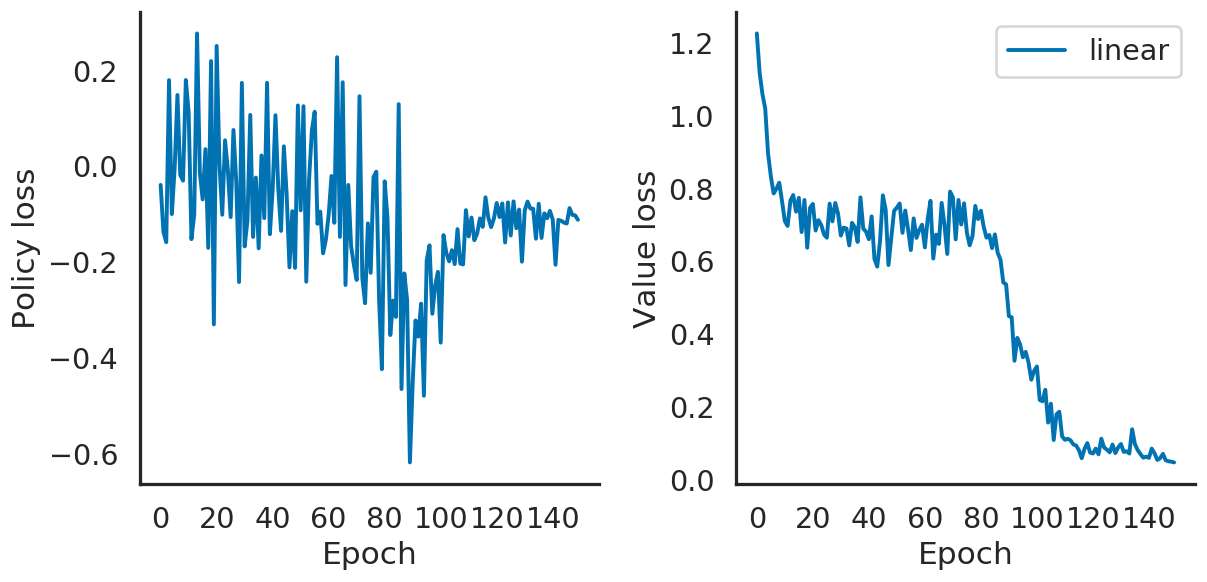

In [11]:
'''loss functions'''

f, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=125)
axes[0].plot(trainer.log_loss_policy.mean(1)[:n_epochs])
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].set_ylabel('Policy loss')
axes[0].set_xlabel('Epoch')

axes[1].plot(trainer.log_loss_value.mean(1)[:n_epochs])
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Value loss')
axes[1].set_xlabel('Epoch')

plt.legend(CUES)
sns.despine()
f.tight_layout()

In [51]:
trainer.log_cum_return.mean(2)[:n_epochs].shape

(150, 3)

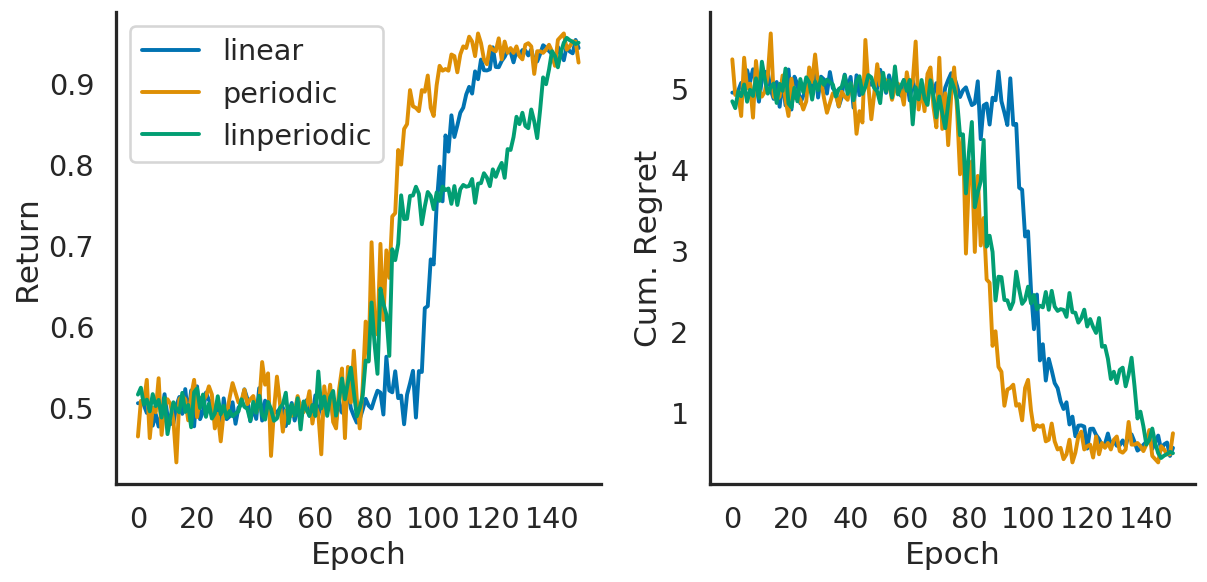

In [12]:
'''learning curves'''

f, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=125)
axes[0].plot(trainer.log_cum_return.mean(2)[:n_epochs])
axes[0].set_ylabel('Return')
axes[0].set_xlabel('Epoch')
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
# axes[0].plot(np.repeat(log_Y[:, 0, :, 7].mean(1).mean(), n_epochs), '_k')

# axes[1].plot(log_regret.mean(3).mean(2)) # mean regreat across trials and rounds
axes[1].plot(trainer.log_regret.cumsum(3).max(3).mean(2)[:n_epochs])
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Cum. Regret')
axes[1].set_xlabel('Epoch')

axes[0].legend(CUES)
sns.despine()
f.tight_layout()

In [28]:
''' model evaluation for different cues'''

block = ['linneg', 'pereven', 'linperiodic'] 
if composition_block is False:
    trainer.dataloaders.evaluate_control()
X, Y, S = trainer.dataloaders.sample(end_rnd=1, block=block)
n_runs = 1000

# create block structure
X, Y, S, _ = trainer.dataloaders.prepare_data(X, Y, S, block, n_trials)
total_trials =  n_trials if trainer.dataloaders.eval_control else len(block) * n_trials
init_at = None

In [29]:
actions, rewards, values, regrets =  np.zeros((n_runs, total_trials)),  np.zeros((n_runs, total_trials)), np.zeros((n_runs, total_trials, n_arms)),  np.zeros((n_runs, total_trials))

for run_id in range(n_runs):
    actions[run_id], rewards[run_id], regrets[run_id], values[run_id] = run_model_eval(agent, X, Y, S)

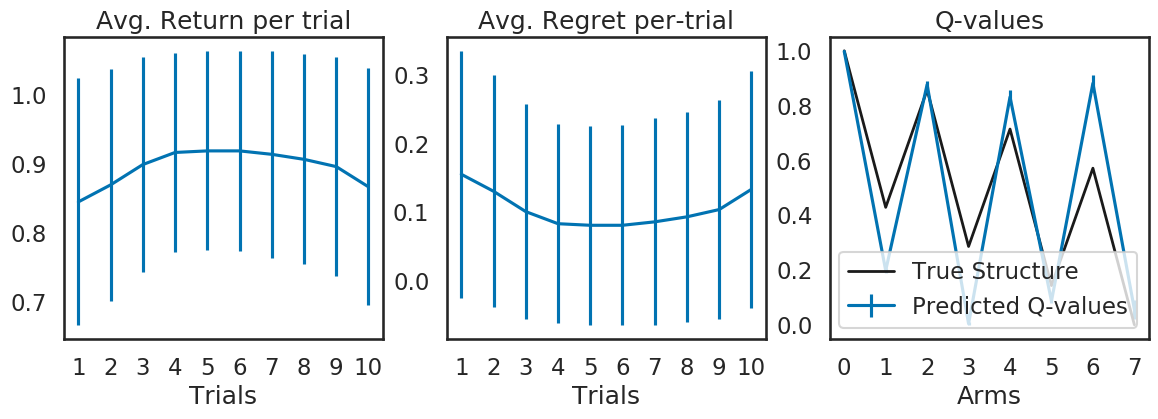

In [30]:
# avg reward across trials
f, ax = plt.subplots(1, 3, figsize=(14, 4), dpi=100)
ax[0].errorbar(range(1, n_trials+1), rewards[:,20:].mean(0), yerr=rewards[:,20:].std(0))
ax[0].set_title('Avg. Return per trial')
ax[0].set_xlabel('Trials')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

# avg regret across trials
ax[1].errorbar(range(1, n_trials+1), regrets[:,20:].mean(0), yerr=regrets[:,20:].std(0))
ax[1].set_title('Avg. Regret per-trial')
ax[1].set_xlabel('Trials')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
 
# avg qvalues
ax[2].plot(Y[29].T, 'k', lw=2, label='True Structure')
ax[2].errorbar(range(n_arms), values[:,20:].mean(0).mean(0), yerr=values[:,20:].mean(0).std(0), label='Predicted Q-values')
ax[2].set_title('Q-values')
ax[2].set_xlabel('Arms')
ax[2].legend(loc='lower right')
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

In [60]:
results_dict = {}
results_dict['composition_curriculum'] = {'actions':actions, 'rewards': rewards, 'regrets':regrets, 'values':values}

In [56]:
train_protocol = 'ControlScheme'
modelname = f"agent_{train_protocol}_{inputs}_hiddim{dim_hidden}_kernel{kernel}_policy{dnd_policy}_blocks{150}.pt"

In [57]:
control_agent = Agent(dim_hidden, dim_output, dict_len, input_dim=inp_dim, ctx_dim=ctx_dim, inputs=inputs, kernel=kernel, dnd_policy=dnd_policy, unique_keys=unique_keys, q_est=estimate_Qvals)
control_agent.load_state_dict(torch.load(modelname))

<All keys matched successfully>

In [58]:
''' model evaluation for different cues'''

block = ['linneg', 'pereven', 'linperiodic'] 
trainer.dataloaders.evaluate_control()
X, Y, S = trainer.dataloaders.sample(end_rnd=1, block=block)
n_runs = 1000

# create block structure
X, Y, S, _ = trainer.dataloaders.prepare_data(X, Y, S, block, n_trials)
total_trials =  n_trials if trainer.dataloaders.eval_control else len(block) * n_trials
init_at = None

In [62]:
actions, rewards, values, regrets =  np.zeros((n_runs, total_trials)),  np.zeros((n_runs, total_trials)), np.zeros((n_runs, total_trials, n_arms)),  np.zeros((n_runs, total_trials))

for run_id in range(n_runs):
    actions[run_id], rewards[run_id], regrets[run_id], values[run_id] = run_model_eval(control_agent, X, Y, S)

In [63]:
results_dict['control_curriculum'] = {'actions':actions, 'rewards': rewards, 'regrets':regrets, 'values':values}

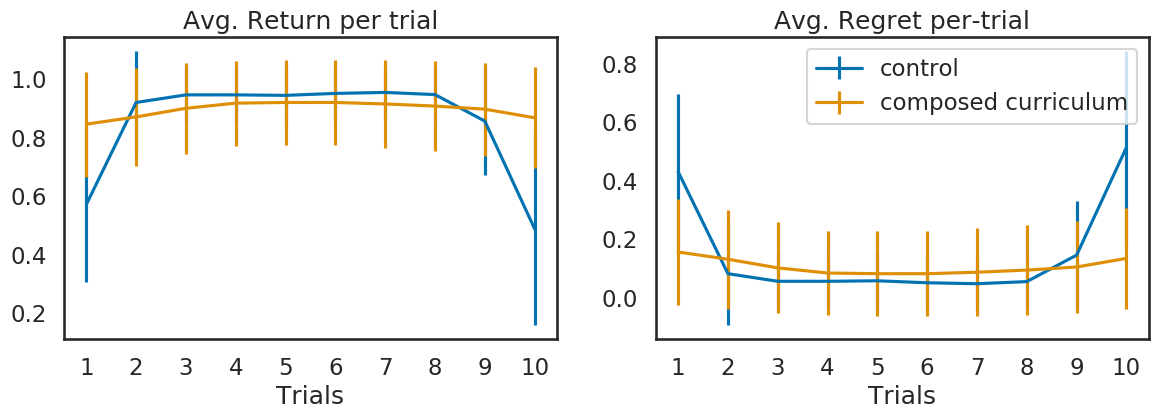

In [76]:
# avg reward across trials
f, ax = plt.subplots(1, 2, figsize=(14, 4), dpi=100)
ax[0].errorbar(range(1, n_trials+1), results_dict['control_curriculum']['rewards'].mean(0), yerr= results_dict['control_curriculum']['rewards'].std(0))
ax[0].errorbar(range(1, n_trials+1), results_dict['composition_curriculum']['rewards'][:,20:].mean(0), yerr=results_dict['composition_curriculum']['rewards'][:,20:].std(0))
ax[0].set_title('Avg. Return per trial')
ax[0].set_xlabel('Trials')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

# avg regret across trials
ax[1].errorbar(range(1, n_trials+1), results_dict['control_curriculum']['regrets'].mean(0), yerr=results_dict['control_curriculum']['regrets'].std(0))
ax[1].errorbar(range(1, n_trials+1), results_dict['composition_curriculum']['regrets'][:,20:].mean(0), yerr=results_dict['composition_curriculum']['regrets'][:,20:].std(0))
ax[1].set_title('Avg. Regret per-trial')
ax[1].set_xlabel('Trials')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].legend(['control', 'composed curriculum'])
# # avg qvaluesZZZZZZ
# ax[2].plot(Y[29].T, 'k', lw=2, label='True Structure')
# ax[2].errorbar(range(n_arms), results_dict['composition_curriculum']['values'][:,20:].mean(0).mean(0), yerr=values[:,20:].mean(0).std(0), label='Predicted Q-values')
# ax[2].set_title('Q-values')
# ax[2].set_xlabel('Arms')
# ax[2].legend(loc='lower right')
# ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

<ErrorbarContainer object of 3 artists>

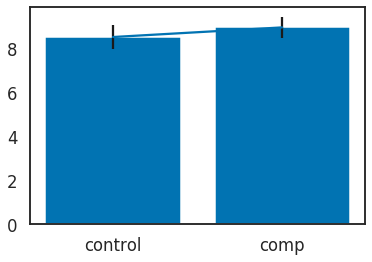

In [98]:
plt.bar(['control', 'comp'],[results_dict['control_curriculum']['rewards'].sum(1).mean(),results_dict['composition_curriculum']['rewards'][:,20:].sum(1).mean()])
plt.errorbar(['control', 'comp'],[results_dict['control_curriculum']['rewards'].sum(1).mean(),results_dict['composition_curriculum']['rewards'][:,20:].sum(1).mean()], yerr=[results_dict['control_curriculum']['rewards'].sum(1).std(),results_dict['composition_curriculum']['rewards'][:,20:].sum(1).std()], ecolor='k')

In [ ]:
# avg reward across trials
f, ax = plt.subplots(1, 2, figsize=(14, 4), dpi=100)
ax[0].errorbar(range(1, n_trials+1), results_dict['control_curriculum']['rewards'].mean(0), yerr= results_dict['control_curriculum']['rewards'].std(0))
ax[0].errorbar(range(1, n_trials+1), results_dict['composition_curriculum']['rewards'][:,20:].mean(0), yerr=results_dict['composition_curriculum']['rewards'][:,20:].std(0))
ax[0].set_title('Avg. Return per trial')
ax[0].set_xlabel('Trials')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

# avg regret across trials
ax[1].errorbar(range(1, n_trials+1), results_dict['control_curriculum']['regrets'].mean(0), yerr=results_dict['control_curriculum']['regrets'].std(0))
ax[1].errorbar(range(1, n_trials+1), results_dict['composition_curriculum']['regrets'][:,20:].mean(0), yerr=results_dict['composition_curriculum']['regrets'][:,20:].std(0))
ax[1].set_title('Avg. Regret per-trial')
ax[1].set_xlabel('Trials')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].legend(['control', 'composed curriculum'])
# # avg qvaluesZZZZZZ
# ax[2].plot(Y[29].T, 'k', lw=2, label='True Structure')
# ax[2].errorbar(range(n_arms), results_dict['composition_curriculum']['values'][:,20:].mean(0).mean(0), yerr=values[:,20:].mean(0).std(0), label='Predicted Q-values')
# ax[2].set_title('Q-values')
# ax[2].set_xlabel('Arms')
# ax[2].legend(loc='lower right')
# ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

In [15]:
def run_model_eval(agent, X, Y, S, init_at=None):
    
    aa, vv, rr, rs =  [], [], [], []
    
    # run model for n_runs
    agent.eval()
    agent.turn_off_encoding()

    # set init states
    h_t, c_t = agent.get_init_states()
    h_t, c_t = torch.zeros_like(h_t), torch.zeros_like(c_t) 
    a_t = init_at
    r_t = Y[0].mean() 
    
    
    # run model
    for t in range(total_trials):
        x_t = X[t] 
        s_t = S[t]
        trial = t%n_trials
        #print(x_t, s_t, r_t)
        if agent.inputs == 'context_block_action_reward':
            one_hot_a_t = one_hot_embedding(a_t, n_arms)
            #print(x_t, s_t, one_hot_a_t, trial, r_t)
            x_t = torch.cat((x_t.type(torch.FloatTensor), s_t.reshape(-1).type(torch.FloatTensor), one_hot_a_t.reshape(-1).type(torch.FloatTensor), 
                             r_t.reshape(-1).type(torch.FloatTensor), torch.tensor(trial).reshape(-1).type(torch.FloatTensor)), dim=0)
        output_t, c = agent(x_t, h_t, c_t)
        a_t, prob_a_t, v_t, h_t, c_t = output_t
        f_t, i_t, o_t, rg_t, m_t, q_t, pa_t = c

        # bootstrap reward from q-values
        r_t = Y[t][a_t]
        

        # predicted q-value
        Q = q_t.detach().numpy().T
        Q = Q - Q.min()
        Q = Q/Q.max()

        # store results
        rs.append(r_t)
        aa.append(a_t) 
        rr.append(Y[t].max() - r_t)
        vv.append(Q)
    
    return torch.stack(aa), torch.stack(rs), torch.stack(rr), np.hstack(vv).T

In [16]:

def one_hot_embedding(arm, num_arms):
    """Embedding labels to one-hot form.

    Args:
      arms: (LongTensor) arms for which embedding is required, sized [N,].
      num_arms: (int) number of arms.

    Returns:
      (tensor) encoded arms, sized [N, #classes].
    """
    y = torch.eye(num_arms) 
    
    return torch.zeros(num_arms) if arm is None else y[arm]
    

In [101]:
''' model evaluation for different cues'''

block = ['linneg', 'pereven', 'linperiodic'] 
X, Y, S = trainer.dataloaders.sample(end_rnd=1, block=block)
ind = 2
n_runs = 10

tensor(1.) 4
tensor([1., 1.]) tensor([2])
tensor(0.8571) tensor(2)
tensor([1., 1.]) tensor([2])
tensor(1.) tensor(0)
tensor([1., 1.]) tensor([2])
tensor(1.) tensor(0)
tensor([1., 1.]) tensor([2])
tensor(1.) tensor(0)
tensor([1., 1.]) tensor([2])
tensor(0.5714) tensor(6)
tensor([1., 1.]) tensor([2])
tensor(0.5714) tensor(6)
tensor([1., 1.]) tensor([2])
tensor(0.5714) tensor(6)
tensor([1., 1.]) tensor([2])
tensor(0.5714) tensor(6)
tensor([1., 1.]) tensor([2])
tensor(0.5714) tensor(6)
tensor([1., 1.]) tensor([2])
tensor(0.5714) tensor(6)


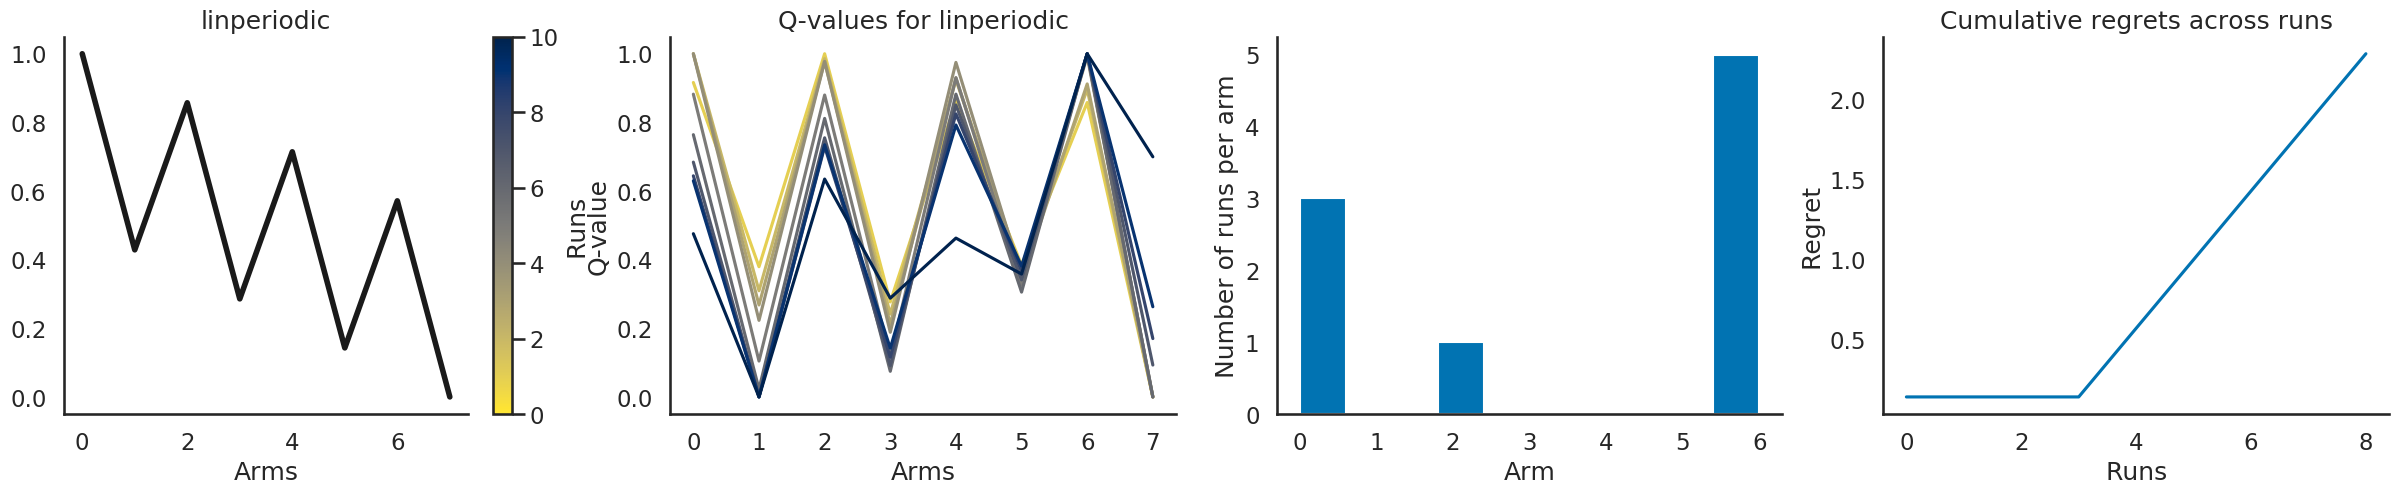

In [102]:
#### n_cues = len(CUES)
 
# set up the color scheme
f, ax = plt.subplots(1, 4, figsize=(30, 5), dpi=100)
c = np.arange(n_runs+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis_r)
cmap.set_array([])

# run model for n_runs
agent.eval()
agent.turn_off_encoding()

# set init states
h_t, c_t = agent.get_init_states()
#h_t, c_t = torch.zeros_like(h_t), torch.zeros_like(c_t)  
a_t = 4 # torch.randint(high=dim_output,size=(1,)) 
r_t = Y[ind-1][a_t] 
print(r_t, a_t)
 
ax[0].plot(Y[ind].T, c='k', lw=4)
ax[0].set(xlabel='Arms', title = block[ind])
actions, dist, values, temps = [], [], [], []

# run model
for t in range(n_runs):
    h_t1 = h_t
    c_t1 = c_t
    x_t = X[ind] 
    s_t = S[ind] #torch.tensor([1])
    print(x_t, s_t)
    if inputs == 'context_block_action_reward':
        one_hot_a_t = one_hot_embedding(a_t, n_arms)
        x_t = torch.cat((x_t.type(torch.FloatTensor), s_t.reshape(-1).type(torch.FloatTensor), one_hot_a_t.reshape(-1).type(torch.FloatTensor), 
                         r_t.reshape(-1).type(torch.FloatTensor), torch.tensor(t%n_trials).reshape(-1).type(torch.FloatTensor)), dim=0)
    output_t, c = agent(x_t, h_t, c_t)
    a_t, prob_a_t, v_t, h_t, c_t = output_t
    f_t, i_t, o_t, rg_t, m_t, q_t, pa_t = c
    a_t = torch.argmax(q_t)
    
    # bootstrap reward from q-values
    r_t = Y[ind][a_t]  
    print(r_t, a_t)
    if t>=0:
        Q = q_t.detach().numpy().T
        Q = Q - Q.min()
        Q = Q/Q.max()
        ax[1].plot(Q, c=cmap.to_rgba(t + 1))
    
    
    dist.append(torch.sum(F.pairwise_distance(h_t1, h_t, p=2)))
    actions.append(a_t) 
    temps.append(1. - r_t) 
    # values.append(q_t[0][aoi[cue]]) 
    
# format figure
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set(xlabel='Arms',
       ylabel='Q-value',
      title= 'Q-values for {}'.format(block[ind]))
cbar = plt.colorbar(cmap, ticks=np.arange(n_runs+1, step=n_runs/5), ax=ax[0])
cbar.set_label('Runs', rotation=90)

_ = ax[2].hist(actions[:t])
ax[2].set(xlabel='Arm',
       ylabel='Number of runs per arm')
ax[3].plot(np.cumsum(torch.stack(temps).cpu().data.numpy())[:t])
ax[3].set(xlabel='Runs',
       ylabel='Regret',
      title='Cumulative regrets across runs')


sns.despine()
plt.show()

In [508]:
''' model evaluation for different cues'''

block = ['linear', 'periodic', 'linperiodic'] #, 'linperiodic']
X, Y, S = trainer.dataloaders.sample(end_rnd=1, block=block)
n_runs = 10

# create block structure
X = np.repeat(X, n_runs, axis=0)
Y = np.repeat(Y, n_runs, axis=0)
S = np.repeat(S, n_runs, axis=0)
init_at = 4 
n_vis = 30

In [509]:
n_cues = len(CUES)
 
# set up the color scheme
c = np.arange(n_vis+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis_r)
cmap.set_array([])

# run model for n_runs
agent.eval()
agent.turn_off_encoding()

# set init states
h_t, c_t = agent.get_init_states()
h_t, c_t = torch.zeros_like(h_t), torch.zeros_like(c_t) 

tensor(0.4286) 4
tensor(1.) tensor(0)
tensor(1.) tensor(0)
tensor(1.) tensor(0)
tensor(1.) tensor(0)
tensor(1.) tensor(0)
tensor(1.) tensor(0)
tensor(1.) tensor(0)
tensor(1.) tensor(0)
tensor(1.) tensor(0)
tensor(1.) tensor(0)
9
tensor(1.7285e-07) 4
tensor(1.) tensor(5)
tensor(1.) tensor(1)
tensor(1.) tensor(1)
tensor(1.) tensor(1)
tensor(1.) tensor(1)
tensor(1.) tensor(3)
tensor(1.) tensor(1)
tensor(1.) tensor(3)
tensor(1.) tensor(1)
tensor(1.) tensor(3)
19
tensor(0.1667) 4
tensor(0.5000) tensor(0)
tensor(0.8333) tensor(3)
tensor(1.) tensor(1)
tensor(1.) tensor(1)
tensor(1.) tensor(1)
tensor(1.) tensor(1)
tensor(1.) tensor(1)
tensor(1.) tensor(1)
tensor(1.) tensor(1)
tensor(0.8333) tensor(3)


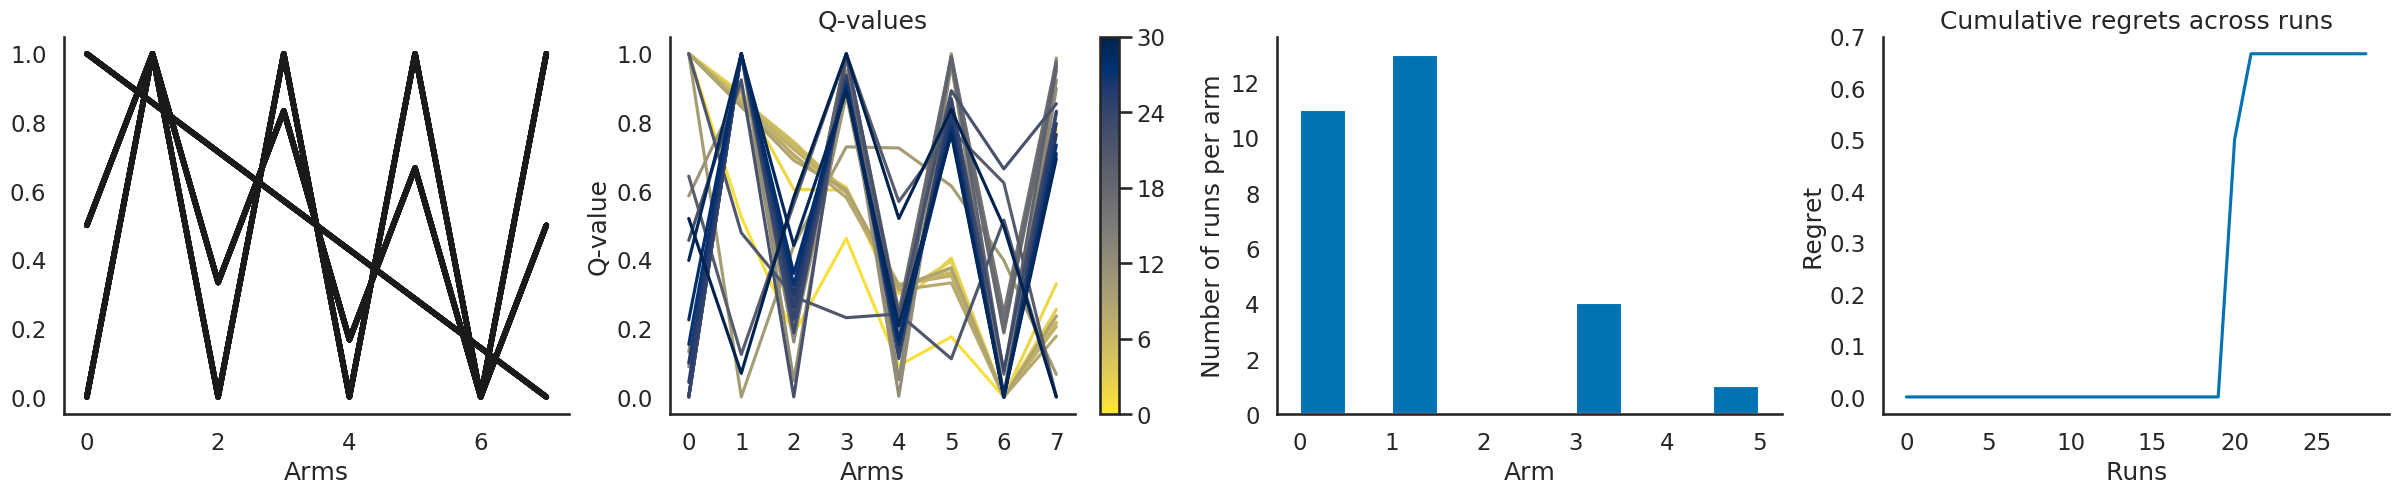

In [510]:
f, ax = plt.subplots(1, 4, figsize=(30, 5), dpi=100)
actions, dist, values, temps = [], [], [], []

r_t = Y[0][init_at] 
print(r_t, init_at)
# run model
for t in range(0, n_vis):
    h_t1 = h_t
    c_t1 = c_t
    x_t = X[t] 
    s_t = S[t]
    
    trial = t%n_trials
    if inputs == 'context_block_action_reward':
        one_hot_a_t = one_hot_embedding(a_t, n_arms)
        x_t = torch.cat((x_t.type(torch.FloatTensor), s_t.reshape(-1).type(torch.FloatTensor), one_hot_a_t.reshape(-1).type(torch.FloatTensor), 
                         r_t.reshape(-1).type(torch.FloatTensor), torch.tensor(trial).reshape(-1).type(torch.FloatTensor)), dim=0)
    output_t, c = agent(x_t, h_t, c_t)
    a_t, prob_a_t, v_t, h_t, c_t = output_t
    f_t, i_t, o_t, rg_t, m_t, q_t, pa_t = c
    a_t = torch.argmax(q_t)
    #if AOI['_'.join(block[:2])] == a_t:
    #    print('chooses best arm in second trial')
    
    # bootstrap reward from q-values
    r_t = Y[t][a_t] 
    print(r_t, a_t)
    
    if t>=0:
        ax[0].plot(Y[t].T, c='k', lw=4)

        Q = q_t.detach().numpy().T
        Q = Q - Q.min()
        Q = Q/Q.max()
        ax[1].plot(Q, c=cmap.to_rgba(t + 1))
        actions.append(a_t) 
        temps.append(1. - r_t)
        
    if (t+1)%n_trials==0 and t<(n_vis-1):
        print(t)
        #h_t, c_t = agent.get_init_states()
        r_t = Y[t+1][init_at]
        print(r_t, init_at)
   
    dist.append(torch.sum(F.pairwise_distance(h_t1, h_t, p=2)))
    
# format figure
ax[0].set(xlabel='Arms')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set(xlabel='Arms',
          ylabel='Q-value',
          title= 'Q-values')
cbar = plt.colorbar(cmap, ticks=np.arange(n_vis+1, step=n_vis/5), ax=ax[1])
cbar.set_label('', rotation=90)

_ = ax[2].hist(actions[:t])
ax[2].set(xlabel='Arm',
       ylabel='Number of runs per arm')
ax[3].plot(np.cumsum(torch.stack(temps).cpu().data.numpy())[:t])
ax[3].set(xlabel='Runs',
       ylabel='Regret',
      title='Cumulative regrets across runs')


sns.despine()
plt.show()